In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from sklearn.metrics import r2_score
from truesight.utils import generate_syntetic_data

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
num_time_steps = 60
season_length = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, season_length, 500)

In [3]:
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"),
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AutoARIMA, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(DecisionTreeRegressor, horizon=forecast_horizon, alias="DecisionTreeRegressor"),
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = forecast_horizon, 
    season_length = season_length,
    date_freq = "MS", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

import pickle
pickle.dump((X_train, Y_train, ids_train, X_val, Y_val, ids_val, models), open("data/synthetic.pkl", "wb"))
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = pickle.load(open("data/synthetic.pkl", "rb"))

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10, verbose = False),
]

In [ ]:
models_wcov = models.copy()
X_train_wcov = X_train.copy()
X_val_wcov = X_val.copy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ts_wcov= TrueSight(models_wcov, num_time_steps, filter_size = 256, context_size = 512, hidden_size = 1024, dropout_rate = 0.2)
ts_wcov.compile(optimizer=optimizer, loss='mse')

ts_wcov.fit(
    x = X_train_wcov, y = Y_train,
    validation_data = [X_val_wcov, Y_val],
    batch_size = 16,
    epochs = 1000,
    verbose = True,
    callbacks = callbacks,
)
ts_wcov.plot_training_history()
ts_wcov.save_weights('ts_wcov.h5')

In [ ]:
models_nocov = models[-1:]
X_train_nocov = X_train[-1:]
X_val_nocov = X_val[-1:]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ts_nocov = TrueSight(models_nocov, num_time_steps, filter_size = 256, context_size = 512, hidden_size = 1024, dropout_rate = 0.2)
ts_nocov.compile(optimizer=optimizer, loss='mse')

ts_nocov.fit(
    x = X_train_nocov, y = Y_train,
    validation_data = [X_val_nocov, Y_val],
    batch_size = 16,
    epochs = 1000,
    verbose = True,
    callbacks = callbacks,
)
ts_nocov.plot_training_history()
ts_nocov.save_weights('nocov.h5')

In [ ]:
yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)

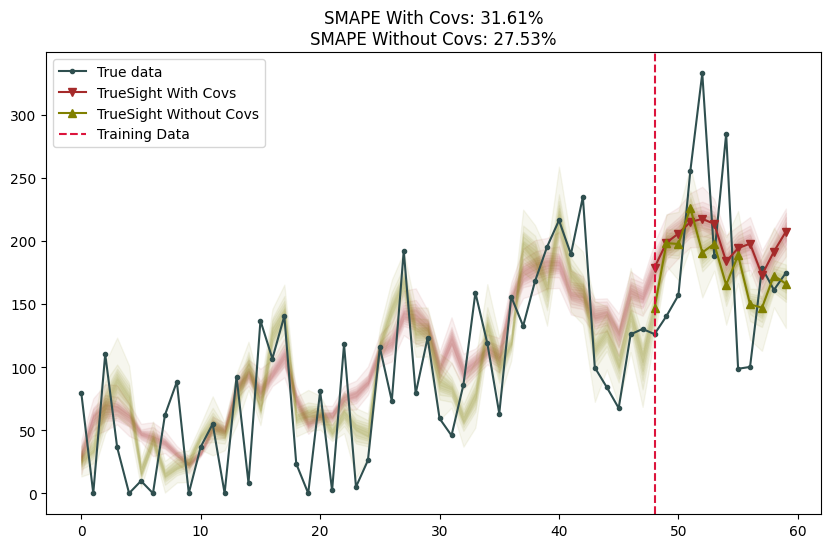

In [ ]:
from matplotlib import pyplot as plt
idx = np.random.randint(0, len(yhat_nocov))
true = Y_val[idx]
pred_wcov = yhat_wcov[:,idx]
pred_nocov = yhat_nocov[:,idx]
_, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.plot(true, ".-", color = "darkslategray", label = "True data")
for i in range(pred_wcov.shape[0] // 2):
    if (i == 0):
        ax.fill_between(np.arange(0, num_time_steps), pred_wcov[-i-1], pred_wcov[i], alpha = 0.5 / (pred_wcov.shape[0] / 2), color = "brown")
    else:
        ax.fill_between(np.arange(0, num_time_steps), pred_wcov[-i-1], pred_wcov[i], alpha = 0.5 / (pred_wcov.shape[0] / 2), color = "brown")

for i in range(pred_nocov.shape[0] // 2):
    if (i == 0):
        ax.fill_between(np.arange(0, num_time_steps), pred_nocov[-i-1], pred_nocov[i], alpha = 0.5 / (pred_nocov.shape[0] / 2), color = "olive")
    else:
        ax.fill_between(np.arange(0, num_time_steps), pred_nocov[-i-1], pred_nocov[i], alpha = 0.5 / (pred_nocov.shape[0] / 2), color = "olive")

#for model_id, model in enumerate(models[:-1]):
#    ax.plot(np.arange(num_time_steps - forecast_horizon, num_time_steps), X_val[model_id][idx], "--", label = model, alpha = 0.5)
    
ax.plot(np.arange(num_time_steps - forecast_horizon, num_time_steps), pred_wcov.mean(axis=0)[-forecast_horizon:], "v-", label = "TrueSight With Covs", color = "brown")
ax.plot(np.arange(num_time_steps - forecast_horizon, num_time_steps), pred_nocov.mean(axis=0)[-forecast_horizon:], "^-", label = "TrueSight Without Covs", color = "olive")
ax.axvline(num_time_steps - forecast_horizon, linestyle = "--", color = 'crimson', label = 'Training Data')
plt.title(f"SMAPE With Covs: {smape(true[-forecast_horizon:], pred_wcov.mean(axis=0)[-forecast_horizon:])*100:.2f}%\n"
          f"SMAPE Without Covs: {smape(true[-forecast_horizon:], pred_nocov.mean(axis=0)[-forecast_horizon:])*100:.2f}%")
plt.legend()
plt.show()

In [ ]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.508953
mape        0.620911
mse      1009.338173
rmse       23.243978
mae        17.380230
dtype: float64

In [ ]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.605017
mape        0.631182
mse      1006.972819
rmse       23.098795
mae        17.470237
dtype: float64

In [ ]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -4.194696937529229
P-Value: 5.960989508184106e-05


In [ ]:
group_a = mape(Y_val, yhat_wcov.mean(axis=0))
group_b = mape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.18566375554778192
P-Value: 0.8530883238131164


In [ ]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.13369916392845604
P-Value: 0.8939118753295798


In [ ]:
group_a = rmse(Y_val, yhat_wcov.mean(axis=0))
group_b = rmse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.4354636686643309
P-Value: 0.6641738480054535


In [ ]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.26743694335893436
P-Value: 0.7896891120722491
